In [ ]:
!nvidia-smi

In [ ]:
import os
import gc
from glob import glob
import random
import copy
import math
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm.notebook import tqdm
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import wandb
import timm

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
Image.MAX_IMAGE_PIXELS = None

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
def seed_everything(random_seed: int):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

In [ ]:
##### HYPER PARAMETER

SEED = 42
IMG_SIZE = (1500, 1500) # width, height
DROP_RATE = 0.4
BATCH_SIZE = 1
BAG_SIZE = 10
EPOCH = 100
PATIENCE = 10
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
PRINT_EVERY = 10
TOPK = 1
GPU_IDX = 0

In [ ]:
seed_everything(SEED)

In [ ]:
df = pd.read_csv('./mel_SN_split_01.csv')
pd.set_option('display.max_rows',None)
# df

,sn,recur,split
0,S 120060820,1,train
1,S 130061619,1,train
2,S 120031607,0,train
3,S 110007570,1,train
4,S 130017153,1,train
5,S 130055018,0,train
6,S 140048589,1,train
7,S 130020036,0,train
8,S 130016080,0,train
9,S 110055499,0,train


In [ ]:
train_list = df.loc[df['split']=='train', 'sn'].tolist()
valid_list = df.loc[df['split']=='valid', 'sn'].tolist()
# test_list = slide_df.loc[slide_df['Split']=='test', 'path'].tolist()

train_label = df.loc[df['split']=='train', 'recur'].tolist()
valid_label = df.loc[df['split']=='valid', 'recur'].tolist()
# test_label = slide_df.loc[slide_df['Split']=='test', 'label'].tolist()

# train_label = [1 if x=='c1' else 0 for x in train_label]
# valid_label = [1 if x=='c1' else 0 for x in valid_label]
# test_label = [1 if x=='c1' else 0 for x in test_label]

In [ ]:
test_list = df.loc[df['split']=='test', 'sn'].tolist()
test_label = df.loc[df['split']=='test', 'recur'].tolist()

In [ ]:
def get_augmentation():
    _transform = [
#         A.Rotate(),
#         A.ColorJitter(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ]
    return A.Compose(_transform)

def get_preprocessing():
    _transform = [
        A.Resize(*IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
    return A.Compose(_transform)

In [ ]:
class MILdataset(Dataset): # MIL-RNN
    def __init__(self, img_path_list, slide_label_list, augmentation=False, preprocessing=False):
        self.img_path_list = img_path_list
        self.slide_label_list = slide_label_list
        self.targets = slide_label_list
        self.augmentation = get_augmentation() if augmentation else None
        self.preprocessing = get_preprocessing() if preprocessing else None
        
        patch_path_list = []
        slide_idx = []
        for i, img_path in enumerate(tqdm(self.img_path_list)):
            cnt = 0
            for path in os.listdir('/workspace/data4/jh/Melanoma_jh/mel_patch_100x_5000_patch/'):
                if path[:11] == img_path:
                    patch_path = f'/workspace/data4/jh/Melanoma_jh/mel_patch_100x_5000_patch/{path}/*.png'
            find_patch = glob(patch_path)
            patch_path_list.extend(find_patch)
            slide_idx.extend([i] * len(find_patch))
        
        self.patch_path_list = patch_path_list
        self.slide_idx = slide_idx
        
    def set_mode(self, mode=1):
        self.mode = mode
        
    def make_train_data(self, idxs):
        self.t_data = [(self.slide_idx[x], self.patch_path_list[x], self.slide_label_list[self.slide_idx[x]]) for x in idxs]
        
    def shuffle_train_data(self):
        self.t_data = random.sample(self.t_data, len(self.t_data))
        
    def __getitem__(self, idx):
        if self.mode == 1:
            slide_idx = self.slide_idx[idx]
            img = cv2.imread(self.patch_path_list[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if self.preprocessing:
                    sample = self.preprocessing(image=img)
                    img = sample['image']
            
            label = self.slide_label_list[slide_idx]
            return img, label
        
        elif self.mode == 2:
            slide_idx, patch_path, label = self.t_data[idx]
            img = cv2.imread(patch_path)
            if self.augmentation:
                    sample = self.augmentation(image=img)
                    img = sample['image']
            if self.preprocessing:
                    sample = self.preprocessing(image=img)
                    img = sample['image']
        return img, label
        
    def __len__(self):
        if self.mode == 1:
            return len(self.patch_path_list)
        
        elif self.mode == 2:
            return len(self.t_data)

In [ ]:
train_data = MILdataset(train_list, train_label, augmentation=True, preprocessing=True)
valid_data = MILdataset(valid_list, valid_label, augmentation=False, preprocessing=True)
# test_data = MILdataset(test_list, test_label, augmentation=False, preprocessing=True)

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
train_data.set_mode(1)
valid_data.set_mode(1)
# test_data.set_mode(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


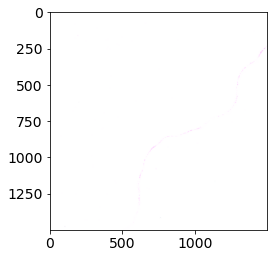

In [ ]:
# test_img = train_data[-1][0].permute(1,2,0)
# plt.imshow(test_img)

In [ ]:
# train_data[-1][0]

tensor([[[2.1462, 2.0605, 2.1633,  ..., 2.1290, 2.0434, 2.1290],
         [1.9578, 2.0434, 2.0948,  ..., 2.0605, 2.0777, 2.0777],
         [1.8893, 1.9235, 1.9578,  ..., 1.9920, 2.1119, 2.0605],
         ...,
         [2.0777, 2.1804, 2.1804,  ..., 2.1633, 2.1633, 2.1633],
         [1.9578, 1.9235, 2.1975,  ..., 2.1633, 2.1633, 2.1633],
         [2.0948, 1.8722, 2.1975,  ..., 2.1633, 2.1633, 2.1633]],

        [[2.2010, 2.1310, 2.2185,  ..., 2.2010, 2.1134, 2.1660],
         [1.9384, 2.0259, 2.0609,  ..., 2.0609, 2.0609, 2.0784],
         [1.7983, 1.8333, 1.8508,  ..., 1.9209, 2.0609, 2.0084],
         ...,
         [2.1485, 2.2885, 2.2710,  ..., 2.3410, 2.3410, 2.3410],
         [2.0259, 1.9909, 2.3235,  ..., 2.3410, 2.3410, 2.3410],
         [2.1660, 1.9559, 2.3060,  ..., 2.3410, 2.3410, 2.3410]],

        [[2.4831, 2.4134, 2.5006,  ..., 2.4483, 2.3960, 2.4657],
         [2.2566, 2.3437, 2.3786,  ..., 2.3786, 2.3786, 2.3786],
         [2.1346, 2.1694, 2.1868,  ..., 2.2566, 2.3960, 2.

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=30)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=30)
# test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

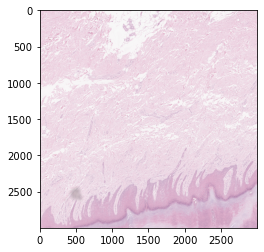

In [ ]:
top_list=[]
tmp=[102, 120, 149, 154, 196, 298, 329, 400, 506, 535, 555, 663, 725, 778, 890, 918, 1055, 1158, 1172, 1293, 1341, 1371, 1606, 1675, 1724, 1825, 1880, 1901, 1930, 2032, 2143, 2180, 2197, 2269, 2293, 2321, 2411, 2442, 2520, 2548, 2640, 2651, 2697, 2734, 2786, 2843, 2893, 3003, 3101, 3130, 3217, 3355, 3402, 3431, 3495, 3592, 3655, 3751, 3790, 3852, 3895, 4013, 4069, 4135, 4198, 4270, 4325, 4340, 4474, 4523, 4650, 4696, 4760, 4769, 4804, 4892, 4960, 4989, 5090, 5145, 5176, 5259, 5330, 5444, 5546, 5665]
for i in tmp:
    top_list.append(train_data.patch_path_list[i])
img_read=plt.imread(top_list[0])
plt.imshow(img_read)

In [ ]:
model = timm.create_model('resnet50', pretrained=True, num_classes=2, drop_rate=DROP_RATE)
model = model.to(GPU_IDX)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)#, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def inference(loader, model):
    model.eval()
    probs = torch.FloatTensor(len(loader.dataset))
    with torch.no_grad():
        for i, (input, target) in enumerate(tqdm(loader)):
            input = input.to(GPU_IDX)
            output = F.softmax(model(input), dim=1)
            probs[i*BATCH_SIZE:i*BATCH_SIZE+input.size(0)] = output.detach()[:,1].clone()
    return probs.cpu().numpy()

def loss_inference(loader, model, criterion):
    model.eval()
    probs = torch.FloatTensor(len(loader.dataset))
    running_loss = 0.
    with torch.no_grad():
        for i, (input, target) in enumerate(tqdm(loader)):
            input = input.to(GPU_IDX)
            target = target.to(GPU_IDX)
            output = model(input)
            loss = criterion(output, target)
            running_loss += loss.item()*input.size(0)
            output = F.softmax(output, dim=1)
            probs[i*BATCH_SIZE:i*BATCH_SIZE+input.size(0)] = output.detach()[:,1].clone()
    return probs.cpu().numpy(), running_loss/len(loader.dataset)

def train(run, loader, model, criterion, optimizer):
    model.train()
    running_loss = 0.
    label, pred = [], []
    for i, (input, target) in enumerate(tqdm(loader)):
        input = input.to(GPU_IDX)
        target = target.to(GPU_IDX)
        output = model(input)
        label.extend(target.detach().cpu().numpy())
        pred.extend(output.argmax(axis=1).detach().cpu().numpy())
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*input.size(0)
        
        # if i % PRINT_EVERY == 0:
        #     print(f'{i}\t{running_loss/len(loader.dataset):.4f}\t{accuracy_score(label, pred):4f}')
    plot_confusion_matrix(confusion_matrix(label, pred), classes=['no recur', 'recur'], title='train')
    plt.show()
    return running_loss/len(loader.dataset), accuracy_score(label, pred)

def calc_err(pred,real):
    pred = np.array(pred)
    real = np.array(real)
    neq = np.not_equal(pred, real)
    err = float(neq.sum())/pred.shape[0]
    fpr = float(np.logical_and(pred==1,neq).sum())/(real==0).sum()
    fnr = float(np.logical_and(pred==0,neq).sum())/(real==1).sum()
    return err, fpr, fnr

def group_argtopk(groups, data,k=1):
    order = np.lexsort((data, groups))
    groups = groups[order]
    data = data[order]
    index = np.empty(len(groups), 'bool')
    index[-k:] = True
    index[:-k] = groups[k:] != groups[:-k]
    return list(order[index])

def group_max(groups, data, nmax):
    out = np.empty(nmax)
    out[:] = np.nan
    order = np.lexsort((data, groups))
    groups = groups[order]
    data = data[order]
    index = np.empty(len(groups), 'bool')
    index[-1] = True
    index[:-1] = groups[1:] != groups[:-1]
    out[groups[index]] = data[index]
    return list(out)

# def group_argtopk_test(groups, data,k=1):
#     order = np.lexsort((data, groups))
#     groups = groups[order]
#     data = data[order]
#     index = np.empty(len(groups), 'bool')
#     index[-k:] = True
#     index[:-k] = groups[k:] != groups[:-k]
#     return index,order,groups

In [ ]:

seed_everything(SEED)

best_epoch = -1
best_valid_loss = 10000
ls_cnt = 0

for epoch in tqdm(range(EPOCH)):
    print(f'Epoch {epoch}')
    
    # train
    train_data.set_mode(1)
    probs = inference(train_dataloader, model)
    print(len(probs))
    print(np.array(train_data.slide_idx),len(probs))
    test_top=group_argtopk_test(np.array(train_data.slide_idx), probs, TOPK)
    print(test_top)
    topk = group_argtopk(np.array(train_data.slide_idx), probs, TOPK)
    print(topk)
    train_data.make_train_data(topk)
    train_data.shuffle_train_data()
    train_data.set_mode(2)
    train_loss, train_acc = train(epoch, train_dataloader, model, criterion, optimizer)
    print(f'train\tLoss: {train_loss:.4f}\tAcc: {train_acc:.4f}')
    
    #save model
    torch.save(model.state_dict(), f'/workspace/src/jh/MIL_model_save_jh/v2_100x_top5_{epoch}.pth')

    # valid
    valid_data.set_mode(1)
    probs, valid_loss = loss_inference(valid_dataloader, model, criterion)
    print(len(probs))
    maxs = group_max(np.array(valid_data.slide_idx), probs, len(valid_data.targets))
    print(maxs)
    pred = [1 if x >= 0.5 else 0 for x in maxs]
    valid_acc = accuracy_score(pred, valid_data.targets)
    plot_confusion_matrix(confusion_matrix(valid_data.targets, pred), classes=['no recur', 'recur'], title='test')
    plt.show()
    print(f'valid\tLoss: {valid_loss:.4f}\tAcc:{valid_acc:.4f}')

    
    if best_valid_loss > valid_loss:
        if ls_cnt > 0:
            del model_state
        model_state = copy.deepcopy(model.state_dict())
        best_epoch = epoch
        best_valid_loss = valid_loss
        ls_cnt = 0
    else:
        ls_cnt += 1
        if ls_cnt == PATIENCE:
            print('early stop')
            break 
    
    print()
    # gc.collect()
    # torch.cuda.empty_cache()
    
print(f'best epoch: {best_epoch}')